In [33]:
from pathlib import Path
import json

# --- Path and Directory Definitions ---
def find_project_root(marker: str = ".git") -> Path:
    current_path = Path.cwd().resolve()
    while current_path != current_path.parent:
        if (current_path / marker).exists():
            return current_path
        current_path = current_path.parent
    raise FileNotFoundError(f"Could not find project root. Marker '{marker}' not found.")

PROJECT_ROOT = find_project_root()
DATA_DIR = PROJECT_ROOT / 'data'

# Yewei
DIR_1001_1500_COMPUTATIONAL = PROJECT_ROOT / 'yewei' / 'gsm8k_data' / 'computational'
DIR_1001_1500_CONCEPTUAL = PROJECT_ROOT / 'yewei' / 'gsm8k_data' / 'conceptual'

# Ling
DIR_1500_1599_CONCEPTUAL = DATA_DIR

# Mauro
DIR_500_999_MIXED = DATA_DIR / 'manually_gen_incorrect_answers_gsm8k'

# Ali
DIR_0_400_MIXED = PROJECT_ROOT / 'GSM8_Edited'

# Check if all the directories exist
for directory in [
    DIR_1001_1500_COMPUTATIONAL,
    DIR_1001_1500_CONCEPTUAL,
    DIR_1500_1599_CONCEPTUAL,
    DIR_500_999_MIXED,
    DIR_0_400_MIXED
]:
    if not directory.exists():
        print(f"Directory does not exist: {directory}")


filepaths = {
    # Yewei
    "1001_1500_computational": DIR_1001_1500_COMPUTATIONAL / "gsm8k_augmented_1001_1100_computational.json",
    "1001_1500_conceptual": DIR_1001_1500_CONCEPTUAL / "gsm8k_augmented_1001_1100_conceptual.json",
    "1101_1200_computational": DIR_1001_1500_COMPUTATIONAL / "gsm8k_augmented_1101_1200_computational.json",
    "1101_1200_conceptual": DIR_1001_1500_CONCEPTUAL / "gsm8k_augmented_1101_1200_conceptual.json",
    "1201_1300_computational": DIR_1001_1500_COMPUTATIONAL / "gsm8k_augmented_1201_1300_computational.json",
    "1201_1300_conceptual": DIR_1001_1500_CONCEPTUAL / "gsm8k_augmented_1201_1300_conceptual.json",
    "1301_1400_computational": DIR_1001_1500_COMPUTATIONAL / "gsm8k_augmented_1301_1400_computational.json",
    "1301_1400_conceptual": DIR_1001_1500_CONCEPTUAL / "gsm8k_augmented_1301_1400_conceptual.json",
    "1401_1500_computational": DIR_1001_1500_COMPUTATIONAL / "gsm8k_augmented_1401_1500_computational.json",
    "1401_1500_conceptual": DIR_1001_1500_CONCEPTUAL / "gsm8k_augmented_1401_1500_conceptual.json",

    # Ling
    "1500_1599_conceptual": DIR_1500_1599_CONCEPTUAL / "1500_1599_conceptual.jsonl",

    # Mauro
    "500_999_mixed": DIR_500_999_MIXED / "gsm8k_annotated_500_to_999.jsonl",

    # Ali
    "0_100_mixed": DIR_0_400_MIXED / "0-100.json",
    "101-200_mixed": DIR_0_400_MIXED / "101-200.json",
    "201-300_mixed": DIR_0_400_MIXED / "201_to_300.json",
    "301-400_mixed": DIR_0_400_MIXED / "301_to_400.json"
}

# Output dir for the merged jsonl file
OUTPUT_DIR = DATA_DIR

# Load all files into a single dictionary
all_data = {}
for key, filepath in filepaths.items():
    try:
        with open(filepath) as f:
            if filepath.suffix == ".jsonl":
                # Handle JSONL files
                all_data[key] = [json.loads(line) for line in f]
            else:
                # Handle JSON files
                all_data[key] = json.load(f)
    except Exception as e:
        print(f"Error loading {filepath}: {e}")


from datasets import load_dataset

GSM8K_TRAIN = load_dataset("gsm8k", "main", split="train")


In [34]:
import re
import json
from pathlib import Path
from typing import Dict, List, Union, Optional
from datasets import Dataset

def extract_start_index(key: str) -> int:
    """
    Given a key like "1001_1500_conceptual" or "101-200_mixed",
    return the first integer (e.g. 1001 or 101).
    """
    m = re.search(r"(\d+)", key)
    if not m:
        raise ValueError(f"No integer start index found in key '{key}'")
    return int(m.group(1))

def build_question_index_map(dataset: Dataset) -> Dict[str, int]:
    """
    Build a dict mapping each question string to its index in the GSM8K train split.
    """
    return {
        sample["question"].strip(): idx
        for idx, sample in enumerate(dataset)
    }

def merge_augmented_data(
    all_data: Dict[str, Union[List[dict], dict]],
    filepaths: Dict[str, Path],
    gsm8k_train: Dataset,
    output_dir: Union[str, Path],
    project_root: Path,
    output_filename: str = "manually_generated_errors.jsonl"
) -> None:
    """
    Merge all of your JSON/JSONL files into a single JSONL, adding:
      - "index": the example’s index in the GSM8K train split
      - "filepath": the source filepath, made relative to project_root

    Args:
        all_data:       mapping from your file-key (e.g. "0_100_mixed") to list or dict of records
        filepaths:      same keys → Path to each original JSON/JSONL file
        gsm8k_train:    the HuggingFace Dataset for "gsm8k" train split
        output_dir:     directory in which to write the merged JSONL
        project_root:   Path to your project root, used to relativize filepaths
        output_filename: name of the output JSONL file (default: "merged_augmented_data.jsonl")
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    out_path = output_dir / output_filename

    # build question → index lookup
    q2idx = build_question_index_map(gsm8k_train)

    total_written = 0
    with open(out_path, "w", encoding="utf-8") as fout:
        for key, records in all_data.items():
            records_list = records if isinstance(records, list) else [records]
            start_idx = extract_start_index(key)
            src_path: Optional[Path] = filepaths.get(key)

            # compute filepath relative to project_root (or fallback)
            if src_path is not None:
                try:
                    rel_fp = src_path.relative_to(project_root)
                except ValueError:
                    rel_fp = src_path
            else:
                rel_fp = Path(key)

            for i, rec in enumerate(records_list):
                q = rec.get("question", "").strip()
                idx = q2idx.get(q, start_idx + i)
                merged = {
                    **rec,
                    "index": idx,
                    "filepath": rel_fp.as_posix()
                }
                fout.write(json.dumps(merged, ensure_ascii=False) + "\n")
                total_written += 1

    print(f"Merged {total_written} records → {out_path}")

In [35]:
merge_augmented_data(
    all_data=all_data,
    filepaths=filepaths,
    gsm8k_train=GSM8K_TRAIN,
    output_dir=OUTPUT_DIR,
    project_root=PROJECT_ROOT
)

Merged 1963 records → /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/manually_generated_errors.jsonl


In [36]:
import json
from datasets import load_dataset
from pathlib import Path
from typing import Optional

def verify_merged_jsonl(
    jsonl_path: Path,
    gsm8k_train=None,
    max_display: int = 10
) -> None:
    """
    Verify that each 'question' in the merged JSONL matches the
    GSM8K train split question at the recorded 'index'.

    Args:
        jsonl_path:    Path to your merged_augmented_data.jsonl
        gsm8k_train:   (optional) pre-loaded Dataset; if None, we'll load it for you
        max_display:   number of mismatches to print in detail
    """
    # 1) load GSM8K if not provided
    if gsm8k_train is None:
        gsm8k_train = load_dataset("gsm8k", "main", split="train")

    total = 0
    mismatches = []

    # 2) iterate merged file
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line in f:
            total += 1
            rec = json.loads(line)
            idx = rec.get("index")
            merged_q = rec.get("question", "").strip()

            # 3) fetch original
            try:
                orig_q = gsm8k_train[idx]["question"].strip()
            except (IndexError, KeyError, TypeError):
                mismatches.append((total, idx, merged_q, None))
                continue

            # 4) compare
            if merged_q != orig_q:
                mismatches.append((total, idx, merged_q, orig_q))

    # 5) report
    print(f"Checked {total} records.")
    if not mismatches:
        print("✅ All questions match the GSM8K dataset.")
    else:
        print(f"⚠️  Found {len(mismatches)} mismatches:")
        for record_num, idx, merged_q, orig_q in mismatches[:max_display]:
            print(f"\n  • Record #{record_num} (index={idx}):")
            print(f"      Merged : {merged_q!r}")
            if orig_q is None:
                print("      Original: <index out of range>")
            else:
                print(f"      Original: {orig_q!r}")
        if len(mismatches) > max_display:
            print(f"\n  ...plus {len(mismatches)-max_display} more.")

In [37]:
verify_merged_jsonl(
    jsonl_path=OUTPUT_DIR / "manually_generated_errors.jsonl",
    gsm8k_train=GSM8K_TRAIN,
    max_display=10
)

Checked 1963 records.
⚠️  Found 9 mismatches:

  • Record #1003 (index=1502):
      Merged : "Dani brings two and half dozen cupcakes for her 2nd-grade class.  There are 27 students (including Dani), 1 teacher, and 1 teacher's aid.  If 3 students called in sick that day, how many cupcakes are left after Dani gives one to everyone in the class?"
      Original: 'Dani brings two and half dozen cupcakes for her 2nd-grade class.  There are 27 students (including Dani), 1 teacher, and 1 teacher’s aid.  If 3 students called in sick that day, how many cupcakes are left after Dani gives one to everyone in the class?'

  • Record #1014 (index=1513):
      Merged : "Tom's cat is 8 years old.  His rabbit is half the age of his cat.  His dog is three times as old as his rabbit.  How old is the dog?"
      Original: 'Tom’s cat is 8 years old.  His rabbit is half the age of his cat.  His dog is three times as old as his rabbit.  How old is the dog?'

  • Record #1029 (index=1528):
      Merged : "Ga

In [38]:
import unicodedata
import re

def sanitize_text(text: str) -> str:
    """
    Normalize and clean up a solution string for consistent line splitting.

    Steps:
      1. Unicode-normalize to NFC form.
      2. Convert all CRLF or CR line endings to LF.
      3. Strip trailing whitespace on each line.
      4. Remove any zero-width or non-printable characters.
      5. Trim leading/trailing blank lines.

    Args:
        text: raw solution string (may contain weird unicode or mixed line endings)
    Returns:
        cleaned text with uniform LF endings and no extraneous trailing spaces.
    """
    # 1) Unicode normalize
    text = unicodedata.normalize("NFC", text)

    # 2) Normalize line endings
    text = text.replace("\r\n", "\n").replace("\r", "\n")

    # 3) Strip trailing whitespace and remove non-printables
    #    (e.g. zero-width spaces, etc.)
    def clean_line(line: str) -> str:
        # remove zero-width / control chars except newline
        line = re.sub(r"[\u200B-\u200D\uFEFF]", "", line)
        return line.rstrip()

    lines = [clean_line(ln) for ln in text.split("\n")]

    # 4) Trim leading/trailing blank lines
    while lines and lines[0] == "":
        lines.pop(0)
    while lines and lines[-1] == "":
        lines.pop()

    return "\n".join(lines)

In [39]:
import re
import json
from pathlib import Path
from typing import Dict, List, Optional, Union
from datasets import Dataset, load_dataset

def build_solution_mapping_from_text_nosanitize(
    solution_text: str,
    exclude_FA: bool = True
) -> Dict[str, str]:
    """
    Split raw solution text into a line-numbered dict, without any sanitization.

    Args:
        solution_text: the full multi-line solution string
        exclude_FA:    if True, drop the final "#### {answer}" line entirely
    Returns:
        mapping of "L1", "L2", … to each non-blank line of solution_text
        (and optionally "FA" if exclude_FA=False)
    """
    lines = [ln.strip() for ln in solution_text.splitlines() if ln.strip()]
    mapping: Dict[str, str] = {}

    # if last line is "#### {digits}" treat as final answer
    if lines and re.match(r"^####\s*[\d\.,]+$", lines[-1]):
        fa_line = lines.pop(-1).strip()
        if not exclude_FA:
            mapping["FA"] = fa_line

    for i, line in enumerate(lines, start=1):
        mapping[f"L{i}"] = line

    return mapping


def compute_first_erroneous_line_nosanitize(
    input_jsonl: Union[str, Path],
    output_jsonl: Optional[Union[str, Path]] = None,
    gsm8k_train: Optional[Dataset] = None
) -> Dict[str, List[int]]:
    """
    Like compute_first_erroneous_line, but uses the nosanitize mapping.

    Returns dict with:
      - correct_answer_mismatch
      - wrong_answer_full_matches
      - wrong_answer_weird

    And (if output_jsonl is set) writes an annotated JSONL with
    'erroneous_line_number' added where appropriate.
    """
    if gsm8k_train is None:
        gsm8k_train = load_dataset("gsm8k", "main", split="train")

    cam, wafm, waw = [], [], []
    annotated: List[dict] = []

    with open(input_jsonl, "r", encoding="utf-8") as fin:
        for raw in fin:
            rec = json.loads(raw)
            idx = rec["index"]

            ans_map   = build_solution_mapping_from_text_nosanitize(rec["answer"])
            wrong_map = build_solution_mapping_from_text_nosanitize(rec["wrong_answer"])
            ds_text   = gsm8k_train[idx]["answer"]
            ds_map    = build_solution_mapping_from_text_nosanitize(ds_text)

            # 1) correct-answer mismatch?
            if ans_map != ds_map:
                cam.append(idx)
                annotated.append(rec)
                continue

            # 2) wrong-answer exactly matches full solution?
            if wrong_map == ds_map:
                wafm.append(idx)
                annotated.append(rec)
                continue

            # find first line where wrong ≠ dataset
            keys = sorted(ds_map.keys(), key=lambda k: int(k[1:]))
            first_diff = next((k for k in keys if wrong_map.get(k) != ds_map.get(k)), None)

            # 3) weird: any later line matches again?
            is_weird = False
            if first_diff:
                start = int(first_diff[1:])
                for k in keys:
                    if int(k[1:]) > start and wrong_map.get(k) == ds_map.get(k):
                        waw.append(idx)
                        is_weird = True
                        break

            if is_weird:
                annotated.append(rec)
                continue

            # 4) normal: annotate the first differing line
            if first_diff:
                rec["erroneous_line_number"] = first_diff
            annotated.append(rec)

    if output_jsonl:
        out = Path(output_jsonl)
        with out.open("w", encoding="utf-8") as fout:
            for rec in annotated:
                fout.write(json.dumps(rec, ensure_ascii=False) + "\n")
        print(f"Wrote annotated JSONL to {out}")

    return {
        "correct_answer_mismatch": cam,
        "wrong_answer_full_matches": wafm,
        "wrong_answer_weird": waw
    }

In [40]:
results = compute_first_erroneous_line_nosanitize(
    input_jsonl= DATA_DIR / "manually_generated_errors.jsonl",
    output_jsonl= DATA_DIR / "manually_generated_errors_final.jsonl"
)


Wrote annotated JSONL to /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/manually_generated_errors_final.jsonl


In [41]:
print("Correct answers from manually gen files that don't match GSM8K answers:")
print(results["correct_answer_mismatch"])
print()

print("Wrong answers that fully match GSM8K answers:")
print(results["wrong_answer_full_matches"])
print()

print("Wrong answers that are weird (one line differs, but later lines match):")
print(results["wrong_answer_weird"])
print()

Correct answers from manually gen files that don't match GSM8K answers:
[1513, 1533, 1539, 1544, 1556, 1557, 1559, 1560, 3, 12, 20, 44, 105, 108, 109, 137, 167, 168, 198, 200, 269, 317, 378, 399]

Wrong answers that fully match GSM8K answers:
[881]

Wrong answers that are weird (one line differs, but later lines match):
[1001, 1019, 1028, 1030, 1031, 1033, 1039, 1042, 1054, 1062, 1066, 1068, 1069, 1072, 1073, 1074, 1075, 1085, 1093, 1001, 1010, 1030, 1031, 1066, 1069, 1102, 1112, 1124, 1125, 1131, 1133, 1136, 1140, 1143, 1149, 1152, 1153, 1154, 1156, 1159, 1160, 1163, 1164, 1169, 1192, 1193, 1196, 1122, 1125, 1146, 1149, 1184, 1189, 1196, 1202, 1205, 1206, 1212, 1213, 1219, 1221, 1222, 1225, 1226, 1227, 1229, 1233, 1242, 1250, 1251, 1253, 1256, 1259, 1264, 1267, 1269, 1271, 1274, 1286, 1289, 1292, 1295, 1205, 1219, 1231, 1250, 1251, 1269, 1289, 1292, 1302, 1354, 1361, 1362, 1363, 1364, 1372, 1375, 1379, 1380, 1385, 1391, 1393, 1302, 1334, 1338, 1375, 1385, 1391, 1393, 1408, 1410, 1412,

In [42]:
import json
from pathlib import Path

# --- 1. Define Paths ---

input_path = DATA_DIR / "manually_generated_errors_final.jsonl"
output_path = input_path.with_name(f"{input_path.stem}_pretty.json")

# --- 2. Define the Conversion Function ---
def convert_jsonl_to_pretty_json(
    jsonl_input_path: Path,
    json_output_path: Path,
    indent: int = 2
):
    """
    Reads a JSONL file and writes its contents as a single,
    nicely formatted JSON array to a new file.

    Args:
        jsonl_input_path: Path to the source JSONL file.
        json_output_path: Path to the destination pretty-printed JSON file.
        indent: The indentation level for the output JSON.
    """
    print(f"Reading records from: {jsonl_input_path}")
    records = []
    try:
        with jsonl_input_path.open("r", encoding="utf-8") as f_in:
            for line in f_in:
                # Ignore blank lines
                if line.strip():
                    records.append(json.loads(line))

        print(f"Successfully read {len(records)} records.")

        print(f"Writing nicely formatted JSON to: {json_output_path}")
        with json_output_path.open("w", encoding="utf-8") as f_out:
            # Use json.dump to write the entire list with indentation
            json.dump(records, f_out, indent=indent, ensure_ascii=False)

        print("\nConversion complete.")
        print(f"View the formatted output at: {json_output_path}")

    except FileNotFoundError:
        print(f"ERROR: Input file not found at '{jsonl_input_path}'")
    except json.JSONDecodeError as e:
        print(f"ERROR: Failed to parse JSON from '{jsonl_input_path}'.")
        print(f"Details: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# --- 3. Execute the Conversion ---
convert_jsonl_to_pretty_json(input_path, output_path)

Reading records from: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/manually_generated_errors_final.jsonl
Successfully read 1963 records.
Writing nicely formatted JSON to: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/manually_generated_errors_final_pretty.json

Conversion complete.
View the formatted output at: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/manually_generated_errors_final_pretty.json


In [43]:
import json
import csv
from pathlib import Path

# --- 1. Define Paths ---

jsonl_input_path = DATA_DIR / "manually_generated_errors_final.jsonl"
csv_output_path = jsonl_input_path.with_suffix(".csv")


# --- 2. Define the Conversion Function ---
def convert_jsonl_to_csv(jsonl_path: Path, csv_path: Path):
    """
    Reads a JSONL file and converts it to a CSV file.

    It dynamically creates headers from all keys found in the JSONL objects
    to ensure no data is lost, even with inconsistent record structures.
    """
    try:
        print(f"Reading records from: {jsonl_path}")
        records = []
        with jsonl_path.open("r", encoding="utf-8") as f_in:
            for line in f_in:
                if line.strip():
                    records.append(json.loads(line))
        
        if not records:
            print("Input file is empty. No CSV file created.")
            return

        print(f"Found {len(records)} records. Preparing to write to CSV.")

        # Dynamically create the header from all unique keys in the dataset
        all_keys = set()
        for record in records:
            all_keys.update(record.keys())
        # Sort headers for consistent column order
        headers = sorted(list(all_keys))

        with csv_path.open("w", newline="", encoding="utf-8") as f_out:
            writer = csv.DictWriter(f_out, fieldnames=headers)
            
            # Write the header row
            writer.writeheader()
            
            # Write all records
            writer.writerows(records)

        print("\nConversion complete.")
        print(f"CSV file saved to: {csv_path}")

    except FileNotFoundError:
        print(f"ERROR: Input file not found at '{jsonl_path}'")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


# --- 3. Execute the Conversion ---
convert_jsonl_to_csv(jsonl_input_path, csv_output_path)

Reading records from: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/manually_generated_errors_final.jsonl
Found 1963 records. Preparing to write to CSV.

Conversion complete.
CSV file saved to: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/manually_generated_errors_final.csv


In [44]:
import pandas as pd
df = pd.read_csv(csv_output_path)

# replace 'computational_error' with 'computational' and 'conceptual_error' with 'conceptual'
df['error_type'] = df['error_type'].replace({
    'computational_error': 'computational',
    'conceptual_error': 'conceptual'
})

# save the modified DataFrame back to CSV
df.to_csv(csv_output_path, index=False)
print(f"Updated CSV saved to: {csv_output_path}")

# Display unique values in 'erroneous_line_number' and 'error_type'
for col in ['erroneous_line_number', 'error_type']:
    print(f"Column '{col}' unique values:")
    print(df[col].value_counts())
    print("-"*40)

Updated CSV saved to: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/manually_generated_errors_final.csv
Column 'erroneous_line_number' unique values:
erroneous_line_number
L2    533
L1    491
L3    374
L4    191
L5     83
L6     45
L7     17
L8      4
L9      2
Name: count, dtype: int64
----------------------------------------
Column 'error_type' unique values:
error_type
conceptual       1043
computational     920
Name: count, dtype: int64
----------------------------------------


In [45]:
df_conceptual = df[df['error_type'] == 'conceptual']

# Print list of duplicated indices in the conceptual errors
duplicated_indices = df_conceptual.index[df_conceptual.index.duplicated()].tolist()
print("Duplicated indices in conceptual errors:", duplicated_indices)

Duplicated indices in conceptual errors: []


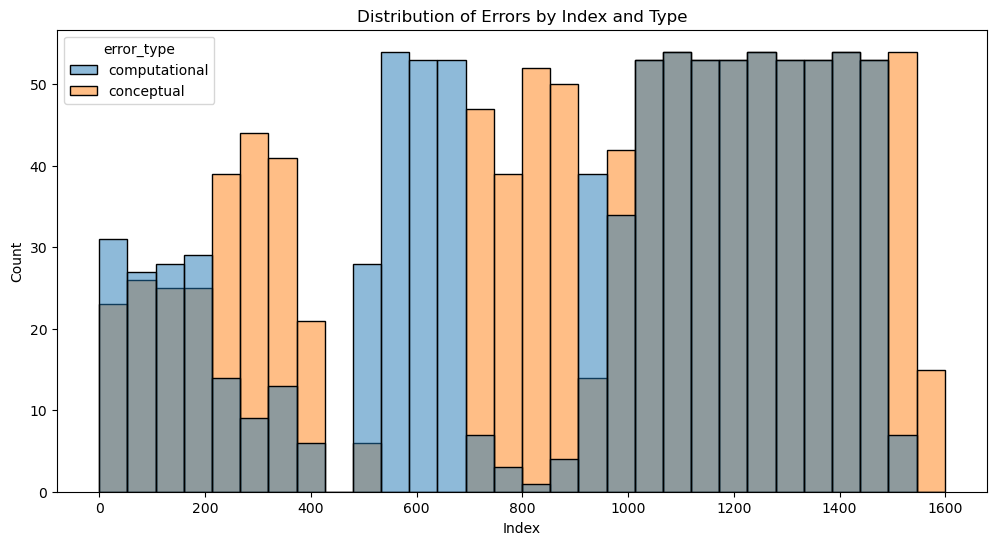

In [48]:
# Plot histogram of index, colored by error type
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='index', hue='error_type', multiple='layer', bins=30, alpha=0.5)
plt.title('Distribution of Errors by Index and Type')
plt.xlabel('Index')
plt.ylabel('Count')
plt.show()

In [49]:
df_conceptual.to_csv(DATA_DIR / 'manually_generated_conceptual_errors.csv', index=False)

In [51]:
L = len(df_conceptual) // 100
for i in range(L):
    start = i * 100
    end = start + 100
    df_conceptual.iloc[start:end].to_csv(DATA_DIR / f'manually_generated_conceptual_errors_{i+1}.csv', index=False)
    print(f"Saved conceptual errors {start} to {end} to CSV.")

Saved conceptual errors 0 to 100 to CSV.
Saved conceptual errors 100 to 200 to CSV.
Saved conceptual errors 200 to 300 to CSV.
Saved conceptual errors 300 to 400 to CSV.
Saved conceptual errors 400 to 500 to CSV.
Saved conceptual errors 500 to 600 to CSV.
Saved conceptual errors 600 to 700 to CSV.
Saved conceptual errors 700 to 800 to CSV.
Saved conceptual errors 800 to 900 to CSV.
Saved conceptual errors 900 to 1000 to CSV.


In [64]:
error_types = {
    "type_1": "operator_swap",
    "type_2": "wrong_reference_group",
    "type_3": "failure_to_update_state",
    "type_4": "operand_swap",
    "type_5": "input_misrepresentation",
    "type_6": "skipped_step",
    "type_7": "unit_handling",
    "type_8": "incorrect_final_answer_selection",
    "type_9": "incorrect_formula_application",
    "type_10": "misinterpreted_scoping_precedence",
    "type_11": "extraneous_operation_invented_method",
    "type_12": "algebraic_simplification_error",
    "type_13": "constraint_violation"
}

### Classification of samples 0-100

In [84]:
# Category 1: Using the wrong mathematical operation (+ vs. *, etc.)
operator_swap = [
    1001, 1002, 1005, 1009, 1010, 1011, 1013, 1020, 1022, 1028,
    1030, 1032, 1034, 1035, 1036, 1037, 1047, 1050, 1051, 1052,
    1053, 1055, 1056, 1060, 1066, 1068, 1071, 1072, 1075, 1076,
    1082, 1087, 1089, 1092, 1094, 1096, 1099
]

# Category 2: Applying a correct calculation to the wrong quantity/group.
wrong_reference_group = [
    1000, 1025, 1026, 1029, 1031, 1039, 1040, 1041, 1048, 1054,
    1065, 1080, 1081, 1084
]

# Category 3: Using a stale value from a previous step instead of an updated one.
failure_to_update_state = [
    1006, 1038, 1045, 1046
]

# Category 4: Swapping operands for a non-commutative operation (e.g., a/b vs b/a).
# No examples of this specific error were found in the provided batch.
operand_swap = []

# Category 5: Using an incorrect number from the text or incorrect world knowledge.
input_misrepresentation = [
    1012, 1018, 1057, 1058, 1063, 1064, 1069, 1070, 1074, 1085,
    1091, 1095
]

# Category 6: Omitting a necessary calculation or reporting an intermediate value.
skipped_step = [
    1003, 1004, 1008, 1014, 1016, 1019, 1021, 1023, 1024, 1027,
    1033, 1043, 1044, 1059, 1061, 1062, 1067, 1073, 1079, 1083,
    1086, 1088, 1090, 1093, 1097, 1098
]

# Category 7: Errors specifically related to unit conversions (often overlaps with other types).
unit_handling_error = [
    1057, 1064, 1070, 1074
]

# New Category 8: Misinterpreting a natural language phrase, leading to an incorrect mathematical setup.
misinterpretation_of_phrase = [
    1007, 1015, 1017, 1028, 1042, 1047, 1049, 1051, 1060, 1071,
    1077, 1078, 1087, 1094
]

samples_0_100 = {
    "type_1": operator_swap,
    "type_2": wrong_reference_group,
    "type_3": failure_to_update_state,
    "type_4": operand_swap,
    "type_5": input_misrepresentation,
    "type_6": skipped_step,
    "type_7": unit_handling_error,
    "type_8": misinterpretation_of_phrase,
    "type_9": [],  # No examples of incorrect final answer selection in this batch
    "type_10": [],  # No examples of misinterpreted scoping/precedence in this batch
    "type_11": [],  # No examples of extraneous operation/invented method in this batch
    "type_12": [],  # No examples of algebraic simplification error in this batch
    "type_13": []   # No examples of constraint violation in this batch
}

### Classification of samples 100-200

In [85]:
# The operator used is incorrect (e.g., '+' instead of '*').
Operator_Swap = [
    1101, 1103, 1108, 1110, 1115, 1116, 1117, 1119, 1120, 1123, 1125,
    1133, 1135, 1146, 1147, 1148, 1149, 1153, 1155, 1156, 1158, 1161,
    1168, 1175, 1177, 1180, 1184, 1185, 1189, 1190, 1196
]

# The calculation uses the wrong variable as an input.
Wrong_Reference_Group = [
    1105, 1109, 1112, 1113, 1121, 1126, 1140, 1143, 1157, 1159, 1163,
    1167, 1169, 1171, 1172, 1176, 1182, 1195, 1197
]

# A specific type of Wrong_Reference_Group where an initial value is used
# instead of an updated, intermediate value.
Failure_To_Update_State = [
    1105, 1112, 1171, 1172
]

# A necessary calculation or logical step is omitted entirely.
Skipped_Step = [
    1100, 1104, 1114, 1129, 1141, 1150, 1162, 1165, 1181, 1192, 1199
]

# An input value from the question or world knowledge is used incorrectly.
# This also includes misinterpreting units in a way that leads to a wrong constant.
Input_Misrepresentation = [
    1131, 1136, 1174, 1187, 1193
]

# An error stemming from a misinterpretation of the problem text that doesn't
# neatly fit the other categories. Often leads to using the wrong operand or logic.
Misinterpretation_of_Problem = [
    1102, 1107, 1111, 1118, 1122, 1124, 1127, 1128, 1130, 1137, 1142,
    1145, 1151, 1152, 1154, 1160, 1164, 1170, 1178, 1179, 1183, 1186,
    1191, 1194
]

# All calculations are correct, but an intermediate value is reported as the
# final answer instead of the true final answer.
Incorrect_Final_Answer_Selection = [
    1106, 1124, 1132, 1138, 1173, 1198
]

# A meta-category for errors occurring during unit conversion.
# These errors are also classified under a more fundamental type above.
Unit_Handling_Error = [
    1136, 1148, 1187
]

samples_100_200 = {
    "type_1": Operator_Swap,
    "type_2": Wrong_Reference_Group,
    "type_3": Failure_To_Update_State,
    "type_4": [],  # No examples of operand swap in this batch
    "type_5": Input_Misrepresentation,
    "type_6": Skipped_Step,
    "type_7": Unit_Handling_Error,
    "type_8": Misinterpretation_of_Problem,
    "type_9": Incorrect_Final_Answer_Selection,
    "type_10": [],  # No examples of misinterpreted scoping/precedence in this batch
    "type_11": [],  # No examples of extraneous operation/invented method in this batch
    "type_12": [],  # No examples of algebraic simplification error in this batch
    "type_13": []   # No examples of constraint violation in this batch
}

### Classification of samples 200-300

In [86]:
# Error Type 1: Operator Swap
operator_swap = [1201, 1203, 1205, 1206, 1207, 1210, 1212, 1213, 1217, 1223, 1232, 1235, 1238, 1240, 1241, 1243, 1244, 1247, 1256, 1258, 1260, 1269, 1272, 1273, 1275, 1276, 1278, 1279, 1280, 1282, 1283, 1285, 1286, 1287, 1288, 1289, 1294, 1296, 1299]

# Error Type 2: Wrong Reference Group
wrong_reference_group = [1208, 1211, 1218, 1219, 1220, 1225, 1227, 1229, 1249, 1252, 1266, 1271, 1277, 1293, 1297]

# Error Type 3: Failure to Update State
failure_to_update_state = [1209, 1224, 1234, 1245, 1270]

# Error Type 4: Operand Swap
# No samples in this set fit the strict definition of swapping operands in a non-commutative operation.

# Error Type 5: Input Misrepresentation
input_misrepresentation = [1202, 1214, 1215, 1233, 1236, 1250, 1251, 1259, 1262, 1292]

# Error Type 6: Skipped Step
skipped_step = [1200, 1204, 1216, 1222, 1226, 1228, 1230, 1231, 1237, 1239, 1246, 1253, 1254, 1255, 1257, 1261, 1263, 1267, 1268, 1281, 1284, 1295, 1298]

# Error Type 7: Unit Handling / Conversion Error
unit_handling_error = [1202, 1233, 1262, 1264]

# Error Type 8: Incorrect Final Answer Selection
incorrect_final_answer_selection = [1221, 1274]

# Error Type 9: Incorrect Formula Application
incorrect_formula_application = [1265, 1290, 1291]

# Notes from ai studio:

# 1242: The "correct" and "wrong" solutions present two different but equally valid logical paths to the same correct answer. The sample does not contain a discernible error.

# 1248: The error described is purely computational (24/2 is evaluated as 10). This does not fit the definition of a conceptual error that could be generated via AST manipulation, as the formula itself is correct.

samples_200_300 = {
    "type_1": operator_swap,
    "type_2": wrong_reference_group,
    "type_3": failure_to_update_state,
    "type_4": [],  # No examples of operand swap in this batch
    "type_5": input_misrepresentation,
    "type_6": skipped_step,
    "type_7": unit_handling_error,
    "type_8": incorrect_final_answer_selection,
    "type_9": incorrect_formula_application,
    "type_10": [],  # No examples of misinterpreted scoping/precedence in this batch
    "type_11": [],  # No examples of extraneous operation/invented method in this batch
    "type_12": [],  # No examples of algebraic simplification error in this batch
    "type_13": []   # No examples of constraint violation in this batch
}

### Classification of samples 300-400

In [87]:
# Error Type 1: Operator Swap
# Emulates using the wrong arithmetic operation (e.g., '+' instead of '*').
operator_swap = [1300, 1302, 1305, 1307, 1309, 1312, 1315, 1318, 1327, 1331, 1332, 1335, 1336, 1343, 1346, 1347, 1348, 1354, 1355, 1357, 1360, 1368, 1370, 1374, 1378, 1389, 1391, 1393, 1397, 1399]

# Error Type 2: Wrong Reference Group
# Emulates applying a correct calculation to the wrong set of items/numbers.
wrong_reference_group = [1303, 1316, 1320, 1324, 1329, 1330, 1333, 1351, 1356, 1359, 1385, 1387, 1388, 1396]

# Error Type 3: Failure to Update State
# Emulates using a stale initial value instead of a recent intermediate value.
failure_to_update_state = [1317, 1375]

# Error Type 4: Operand Swap
# This was not observed in the provided sample. The closest example was index 1320, 
# but it was a swap of operands between *different* operations, better classified as Wrong Reference Group.
operand_swap = []

# Error Type 5: Input Misrepresentation
# Emulates misreading a number from the problem text or using incorrect world knowledge.
input_misrepresentation = [1301, 1321, 1366, 1373]

# Error Type 6: Skipped Step
# Emulates completely omitting a necessary calculation.
skipped_step = [1304, 1306, 1311, 1319, 1341, 1349, 1362, 1364, 1379, 1381, 1392]

# Error Type 7: Unit Handling / Conversion Error
# Emulates a failure to correctly manage units (e.g., minutes vs. seconds, % vs. raw number).
unit_handling_conversion_error = [1311, 1352, 1353]

# Error Type 8: Incorrect Final Answer Selection
# Emulates correctly calculating intermediate values but returning the wrong one as the final answer.
incorrect_final_answer_selection = [1314, 1322, 1325, 1350, 1367, 1371, 1380, 1382, 1398]

# Error Type 10: Misinterpreted Scoping / Precedence
# Emulates misunderstanding linguistic grouping, leading to incorrect order of operations.
misinterpreted_scoping_precedence = [1310, 1337, 1338, 1345, 1358, 1369, 1383, 1394]

# Error Type 11: Extraneous Operation / Invented Method
# Emulates inventing a mathematical procedure not supported by the problem statement.
extraneous_operation_invented_method = [1308, 1313, 1323, 1334, 1339, 1340, 1342, 1344, 1361, 1363, 1365, 1372, 1386, 1390, 1395]

samples_300_400 = {
    "type_1": operator_swap,
    "type_2": wrong_reference_group,
    "type_3": failure_to_update_state,
    "type_4": operand_swap,  
    "type_5": input_misrepresentation,
    "type_6": skipped_step,
    "type_7": unit_handling_conversion_error,
    "type_8": incorrect_final_answer_selection,
    "type_9": [],
    "type_10": misinterpreted_scoping_precedence,
    "type_11": extraneous_operation_invented_method,
    "type_12": [],  # No examples of algebraic simplification error in this batch
    "type_13": []   # No examples of constraint violation in this batch
}

### Classification of samples 400-500

In [ ]:
operator_swap = [1402, 1403, 1406, 1414, 1417, 1418, 1423, 1425, 1428, 1432, 1433, 1436, 1442, 1444, 1445, 1447, 1462, 1466, 1467, 1474, 1478, 1482, 1488, 1489, 1494, 1496, 1497]
wrong_reference_group = [1413]
failure_to_update_state = [1419, 1443, 1472]
input_misrepresentation = [1408, 1435, 1453, 1477, 1483]
skipped_step = [1401, 1421, 1424, 1426, 1427, 1437, 1439, 1449, 1451, 1456, 1464, 1468, 1479, 1492, 1493]
unit_handling_error = [1441, 1445, 1453, 1477]
incorrect_final_answer_selection = [1405, 1410, 1438, 1457, 1498]
incorrect_formula_application = [1455, 1476, 1485]
misinterpreted_scoping = [1400, 1446, 1461, 1465, 1480]
extraneous_operation = [1404, 1409, 1411, 1412, 1415, 1416, 1422, 1430, 1431, 1434, 1440, 1448, 1450, 1454, 1458, 1459, 1460, 1463, 1469, 1470, 1471, 1473, 1475, 1481, 1484, 1486, 1487, 1490, 1491, 1495, 1499]
algebraic_simplification_error = [1420]

samples_400_500 = {
    "type_1": operator_swap,
    "type_2": wrong_reference_group,
    "type_3": failure_to_update_state,
    "type_4": [],  
    "type_5": input_misrepresentation,
    "type_6": skipped_step,
    "type_7": unit_handling_error,
    "type_8": incorrect_final_answer_selection,
    "type_9": incorrect_formula_application,
    "type_10": misinterpreted_scoping_precedence,
    "type_11": extraneous_operation_invented_method,
    "type_12": algebraic_simplification_error,
    "type_13": []  # No examples of constraint violation in this batch
}

### Classification of samples 500-600

In [ ]:
# Type 1: Operator Swap
# Using the wrong arithmetic operator (+, -, *, /).
operator_swap = [
    1506, 1507, 1508, 1509, 1517, 1519, 1521, 1523, 1524, 1526,
    1527, 1534, 1537, 1538, 1541, 1542, 1544, 1545, 1546, 1547,
    1548, 1549, 1560, 501, 508, 509, 700, 702, 704, 705,
    706, 707, 708, 710, 711, 712, 713, 714, 715, 717,
    719, 721, 722, 725, 726, 727, 728, 729, 730
]

# Type 2: Wrong Reference Group
# Applying a correct calculation to the wrong set of items or variables.
wrong_reference_group = [
    1500, 1510, 1512, 1513, 1522, 1529, 1530, 1536, 1542, 1550,
    1556, 701
]

# Type 3: Failure to Update State
# Using a stale initial value instead of an updated intermediate value.
failure_to_update_state = [1501, 1511, 1515, 1532, 1550]

# Type 4: Operand Swap
# Swapping operands for a non-commutative operation (e.g., a-b vs b-a).
# No samples fit this specific definition in the provided data.
operand_swap = []

# Type 5: Input Misrepresentation
# Misreading or misusing a number from the problem text.
input_misrepresentation = [1504, 703, 716, 720]

# Type 6: Skipped Step
# Omitting a necessary calculation or logical step.
skipped_step = [1502, 1503, 1505, 1514, 1520, 1551, 1559, 723, 731]

# Type 7: Unit Handling / Conversion Error
# Errors specifically related to unit conversions (e.g., ft to in, % to decimal).
unit_handling_conversion_error = [1509, 1531, 1549, 1559, 505]

# Type 8: Incorrect Final Answer Selection
# Correctly performing calculations but reporting an intermediate value or the wrong final value.
incorrect_final_answer_selection = [1528, 1557, 1599, 709, 724]

# Type 9: Incorrect Formula Application
# Using a structurally incorrect formula (e.g., part/other_part instead of part/total).
incorrect_formula_application = [1516, 1525, 1533, 1540]

# Type 10: Misinterpreted Scoping / Precedence
# Incorrectly structuring an expression due to misinterpreting language (e.g., order of operations).
misinterpreted_scoping_precedence = [1539, 1552]

# Type 11: Extraneous Operation / Invented Method
# Introducing an operation or method with no basis in the problem statement.
extraneous_operation_invented_method = [
    1518, 1535, 1553, 1554, 502, 507
]

# Type 12: Algebraic Simplification Error
# Making a procedural error while simplifying a correctly set up algebraic expression.
algebraic_simplification_error = [718]

samples_500_600 = {
    "type_1": operator_swap,
    "type_2": wrong_reference_group,
    "type_3": failure_to_update_state,
    "type_4": [],  
    "type_5": input_misrepresentation,
    "type_6": skipped_step,
    "type_7": unit_handling_conversion_error,
    "type_8": incorrect_final_answer_selection,
    "type_9": incorrect_formula_application,
    "type_10": misinterpreted_scoping_precedence,
    "type_11": extraneous_operation_invented_method,
    "type_12": algebraic_simplification_error,
    "type_13": []  # No examples of constraint violation in this batch
}

### Classification of samples 600-700

In [90]:
# Error Type 1: Operator Swap
operator_swap = [732, 734, 736, 738, 739, 740, 741, 742, 745, 746, 747, 748, 760, 761, 763, 765, 766, 767, 769, 770, 771, 773, 775, 776, 778, 779, 780, 782, 783, 784, 785, 787, 788, 789, 793, 794, 795, 796, 798, 800, 802, 804, 805, 806, 809, 811, 812, 813, 815, 816, 817, 819, 820, 821, 822, 823, 824, 826, 827, 828, 829, 833, 834, 837, 839, 841, 843, 846]

# Error Type 2: Wrong Reference Group
wrong_reference_group = [768, 842, 844]

# Error Type 3: Failure to Update State
failure_to_update_state = [737, 764, 810]

# Error Type 4: Operand Swap (No samples of this type were present)
operand_swap = []

# Error Type 5: Input Misrepresentation
input_misrepresentation = [733, 762, 772, 791, 830]

# Error Type 6: Skipped Step
skipped_step = [743, 777, 799, 814, 831, 838]

# Error Type 7: Unit Handling Error
unit_handling_error = [735]

# Error Type 8: Incorrect Final Answer Selection
incorrect_final_answer_selection = [774, 836, 845]

# Error Type 9: Incorrect Formula Application
incorrect_formula_application = [790]

# Error Type 10: Misinterpreted Scoping / Precedence
misinterpreted_scoping = [808]

# Error Type 11: Extraneous Operation / Invented Method
extraneous_operation = [840]

# Error Type 12: Algebraic Simplification Error
algebraic_simplification_error = [744, 792, 801, 807, 825]

# Error Type 13: Constraint Violation (New)
constraint_violation = [803]

# Note: Index 832 had an error in the "correct" solution provided in the CSV,
# where the first line stated a different calculation than was performed.
# It was classified based on the intended logic. I have omitted it from the lists above.
# The `wrong_answer` for index 832 is "He needs 1000 liters of gas...So he needs 1000/500=2 tanks".
# This appears to be a Skipped Step (omitting the `*10` calculation for total liters).
# If you wish to include it, it would go in `skipped_step`.

samples_600_700 = {
    "type_1": operator_swap,
    "type_2": wrong_reference_group,
    "type_3": failure_to_update_state,
    "type_4": operand_swap,  
    "type_5": input_misrepresentation,
    "type_6": skipped_step,
    "type_7": unit_handling_conversion_error,
    "type_8": incorrect_final_answer_selection,
    "type_9": incorrect_formula_application,
    "type_10": misinterpreted_scoping_precedence,
    "type_11": extraneous_operation_invented_method,
    "type_12": algebraic_simplification_error,
    "type_13": constraint_violation
}

### Classification of samples 700-800

In [91]:
# Analysis of manually_generated_conceptual_errors_8.csv
# Total samples analyzed: 69

# Error Type 1: A simple swap of arithmetic operators (e.g., '+' for '-', '*' for '/').
operator_swap_indices = [
    848, 851, 853, 855, 856, 857, 858, 859, 861, 862, 864, 868, 872, 875, 876, 
    878, 879, 882, 883, 885, 887, 889, 891, 893, 894, 895, 897, 898, 899, 900, 
    901, 902, 904, 905, 906, 907, 908, 909, 927, 929, 936, 937, 938, 939, 940, 
    941, 952, 963, 971, 972, 973, 985, 986, 987, 989, 991, 993, 994, 995, 996, 
    997, 998, 999, 1001, 1002, 1003, 1005, 1006, 1007, 1008, 1009
]

# Error Type 2: Applying a correct calculation to the wrong group of items.
wrong_reference_group_indices = [854, 860, 866, 871, 873, 953, 1000]

# Error Type 3: Using a stale initial or intermediate value instead of an updated one.
failure_to_update_state_indices = [847, 849, 850]

# Error Type 6: Omitting a necessary calculation or part of a calculation.
skipped_step_indices = [2, 863, 865, 870, 884, 888, 896, 903, 935, 990]

# Error Type 7: Errors in unit conversion (e.g., hours to minutes) or handling.
unit_handling_conversion_error_indices = [874, 880]

# Error Type 9: Using a fundamentally incorrect formula for the task.
incorrect_formula_application_indices = [988]

# Error Type 11: Inventing an unsupported calculation or method.
extraneous_operation_invented_method_indices = [992]

# Error Type 12: Errors in algebraic simplification.
algebraic_simplification_indices = []

# Error Type 13: Violating a qualitative condition or constraint from the problem.
constraint_violation_indices = []

# Note: The following error types had no matching samples in this specific CSV file.
operand_swap_indices = []
input_misrepresentation_indices = []
incorrect_final_answer_selection_indices = []
misinterpreted_scoping_precedence_indices = []

samples_700_800 = {
    "type_1": operator_swap_indices,
    "type_2": wrong_reference_group_indices,
    "type_3": failure_to_update_state_indices,
    "type_4": operand_swap_indices,  
    "type_5": input_misrepresentation_indices,
    "type_6": skipped_step_indices,
    "type_7": unit_handling_conversion_error_indices,
    "type_8": incorrect_final_answer_selection_indices,
    "type_9": incorrect_formula_application_indices,
    "type_10": misinterpreted_scoping_precedence_indices,
    "type_11": extraneous_operation_invented_method_indices,
    "type_12": algebraic_simplification_indices,
    "type_13": constraint_violation_indices
}

### Classification of samples 800-900

In [92]:
# Error Type 1: Operator Swap
# Emulates: Using the wrong mathematical operation (+, -, *, /).
error_type_1_operator_swap = [20, 22, 39, 48, 53, 70, 77, 126, 146, 170, 196]

# Error Type 2: Wrong Reference Group
# Emulates: Applying a correct calculation to the wrong set of items.
error_type_2_wrong_reference_group = [10, 13, 100, 112, 156, 164]

# Error Type 3: Failure to Update State
# Emulates: Using a stale initial value instead of a recent intermediate one.
error_type_3_failure_to_update_state = [36, 113, 121, 210]

# Error Type 5: Input Misrepresentation
# Emulates: Misreading a number from the problem text or using incorrect world knowledge.
error_type_5_input_misrepresentation = [4, 6, 11, 25, 26, 29, 62, 66, 84, 89, 90, 98, 153, 175, 177, 187]

# Error Type 6: Skipped Step
# Emulates: Completely omitting a necessary calculation.
error_type_6_skipped_step = [16, 43, 45, 51, 57, 63, 65, 78, 80, 86, 103, 116, 130, 134, 163, 165, 184, 190, 201, 208, 216]

# Error Type 7: Unit Handling / Conversion Error
# Emulates: Failures in managing or converting units.
error_type_7_unit_handling_error = [4, 26, 89, 90, 145, 176]

# Error Type 8: Incorrect Final Answer Selection
# Emulates: Reporting a correct intermediate value instead of the final answer.
error_type_8_incorrect_final_answer_selection = [31, 37, 74, 87, 105, 108, 115, 117, 127, 133, 140, 144, 149, 151, 160, 167]

# Error Type 10: Misinterpreted Scoping / Precedence
# Emulates: An error in the order of operations or mathematical grouping.
error_type_10_misinterpreted_scoping = [98, 136]

# Error Type 11: Extraneous Operation / Invented Method
# Emulates: Inventing a completely unsupported mathematical procedure.
error_type_11_extraneous_operation = [19, 59, 93, 102, 142, 174, 205, 211]

# Error Type 13: Constraint Violation
# Emulates: Failing to satisfy a key qualitative condition of the problem.
error_type_13_constraint_violation = [83, 181, 193, 213, 214]

samples_800_900 = {
    "type_1": error_type_1_operator_swap,
    "type_2": error_type_2_wrong_reference_group,
    "type_3": error_type_3_failure_to_update_state,
    "type_4": [],  # No examples of operand swap in this batch
    "type_5": error_type_5_input_misrepresentation,
    "type_6": error_type_6_skipped_step,
    "type_7": error_type_7_unit_handling_error,
    "type_8": error_type_8_incorrect_final_answer_selection,
    "type_9": [],  # No examples of incorrect formula application in this batch
    "type_10": error_type_10_misinterpreted_scoping,
    "type_11": error_type_11_extraneous_operation,
    "type_12": [],  # No examples of algebraic simplification error in this batch
    "type_13": error_type_13_constraint_violation
}

### Classification of samples 900-1000

In [93]:
type1_operator_swap = [230, 236, 237, 248, 250, 255, 263, 271, 276, 282, 291, 308, 313, 315, 316, 325, 335]

type2_wrong_reference_group = [220, 227, 231, 232, 246, 265, 296, 322]

type3_failure_to_update_state = [283]

type4_operand_swap = []

type5_input_misrepresentation = [225, 233, 234, 238, 239, 242, 252, 257, 258, 260, 264, 267, 268, 270, 272, 273, 277, 287, 288, 290, 297, 299, 300, 305, 309, 312, 326, 328, 334, 338, 344]

type6_skipped_step = [223, 247, 249, 251, 269, 278, 279, 281, 292, 293, 295, 302, 311, 317, 318, 319, 320, 323, 327, 333, 336, 337, 340]

type7_unit_handling_conversion_error = [242, 260, 343]

type8_incorrect_final_answer_selection = [221, 235, 240, 245, 259, 261, 284, 301, 304, 306, 310]

type9_incorrect_formula_application = [224, 253, 341]

type10_misinterpreted_scoping_precedence = [274, 321, 331]

type11_extraneous_operation_invented_method = [229]

type12_algebraic_simplification_error = []

type13_constraint_violation = [303]

samples_900_1000 = {
    "type_1": type1_operator_swap,
    "type_2": type2_wrong_reference_group,
    "type_3": type3_failure_to_update_state,
    "type_4": type4_operand_swap,  
    "type_5": type5_input_misrepresentation,
    "type_6": type6_skipped_step,
    "type_7": type7_unit_handling_conversion_error,
    "type_8": type8_incorrect_final_answer_selection,
    "type_9": type9_incorrect_formula_application,
    "type_10": type10_misinterpreted_scoping_precedence,
    "type_11": type11_extraneous_operation_invented_method,
    "type_12": type12_algebraic_simplification_error,
    "type_13": type13_constraint_violation
}

In [98]:
dicts = [
    samples_0_100,
    samples_100_200,
    samples_200_300,
    samples_300_400,
    samples_400_500,
    samples_500_600,
    samples_600_700,
    samples_700_800,
    samples_800_900,
    samples_900_1000
]

for i, d in enumerate(dicts):
    print(f"Dictionary {i}:")
    for k, v in d.items():
        print(f"  {k}: {len(v)} samples")

Dictionary 0:
  type_1: 37 samples
  type_2: 14 samples
  type_3: 4 samples
  type_4: 0 samples
  type_5: 12 samples
  type_6: 26 samples
  type_7: 4 samples
  type_8: 14 samples
  type_9: 0 samples
  type_10: 0 samples
  type_11: 0 samples
  type_12: 0 samples
  type_13: 0 samples
Dictionary 1:
  type_1: 31 samples
  type_2: 19 samples
  type_3: 4 samples
  type_4: 0 samples
  type_5: 5 samples
  type_6: 11 samples
  type_7: 3 samples
  type_8: 24 samples
  type_9: 6 samples
  type_10: 0 samples
  type_11: 0 samples
  type_12: 0 samples
  type_13: 0 samples
Dictionary 2:
  type_1: 39 samples
  type_2: 15 samples
  type_3: 5 samples
  type_4: 0 samples
  type_5: 10 samples
  type_6: 23 samples
  type_7: 4 samples
  type_8: 2 samples
  type_9: 3 samples
  type_10: 0 samples
  type_11: 0 samples
  type_12: 0 samples
  type_13: 0 samples
Dictionary 3:
  type_1: 30 samples
  type_2: 14 samples
  type_3: 2 samples
  type_4: 0 samples
  type_5: 4 samples
  type_6: 11 samples
  type_7: 3 samp

In [101]:
from collections import defaultdict

dicts = [
    samples_0_100,
    samples_100_200,
    samples_200_300,
    samples_300_400,
    samples_400_500,
    samples_500_600,
    samples_600_700,
    samples_700_800,
    samples_800_900,
    samples_900_1000
]

merged = defaultdict(list)
for d in dicts:
    for k, v in d.items():
        merged[k] += v  # Concatenate lists for each key
        merged[k] = sorted(set(merged[k]))

conceptual_error_lists = dict(merged)

In [102]:
total_indices = sum(len(v) for v in conceptual_error_lists.values())
print(f"Total indices across all categories: {total_indices}")

Total indices across all categories: 959


In [103]:
final_error_dict = {}
for error_type, indices in conceptual_error_lists.items():
    final_error_dict[error_type] = {
        "name": error_types[error_type],
        "indices": indices,
        "count": len(indices)
    }

In [104]:
for error_type, details in final_error_dict.items():
    print(f"Error Type: {error_type} - {details['name']}")
    print(f"  Count: {details['count']}")
    print(f"  Indices: {details['indices']}\n")

Error Type: type_1 - operator_swap
  Count: 376
  Indices: [20, 22, 39, 48, 53, 70, 77, 126, 146, 170, 196, 230, 236, 237, 248, 250, 255, 263, 271, 276, 282, 291, 308, 313, 315, 316, 325, 335, 501, 508, 509, 700, 702, 704, 705, 706, 707, 708, 710, 711, 712, 713, 714, 715, 717, 719, 721, 722, 725, 726, 727, 728, 729, 730, 732, 734, 736, 738, 739, 740, 741, 742, 745, 746, 747, 748, 760, 761, 763, 765, 766, 767, 769, 770, 771, 773, 775, 776, 778, 779, 780, 782, 783, 784, 785, 787, 788, 789, 793, 794, 795, 796, 798, 800, 802, 804, 805, 806, 809, 811, 812, 813, 815, 816, 817, 819, 820, 821, 822, 823, 824, 826, 827, 828, 829, 833, 834, 837, 839, 841, 843, 846, 848, 851, 853, 855, 856, 857, 858, 859, 861, 862, 864, 868, 872, 875, 876, 878, 879, 882, 883, 885, 887, 889, 891, 893, 894, 895, 897, 898, 899, 900, 901, 902, 904, 905, 906, 907, 908, 909, 927, 929, 936, 937, 938, 939, 940, 941, 952, 963, 971, 972, 973, 985, 986, 987, 989, 991, 993, 994, 995, 996, 997, 998, 999, 1001, 1002, 1003, 1005

In [109]:
import random 

random.seed(42)  # For reproducibility
sampled_errors = {}
for error_type, details in final_error_dict.items():
    if details['count'] > 0:
        sampled_indices = random.sample(details['indices'], min(10, details['count']))
        sampled_errors[error_type] = {
            "name": details['name'],
            "indices": sampled_indices
        }

In [110]:
for error_type, details in sampled_errors.items():
    print(f"Error Type: {error_type} - {details['name']}")
    print(f"  Indices: {details['indices']}\n")

Error Type: type_1 - operator_swap
  Indices: [1403, 738, 236, 883, 855, 829, 767, 729, 1478, 1272]

Error Type: type_2 - wrong_reference_group
  Indices: [265, 1324, 1182, 156, 112, 1029, 1039, 1229, 1330, 1297]

Error Type: type_3 - failure_to_update_state
  Indices: [1038, 1419, 1046, 1515, 1172, 847, 1375, 36, 1317, 737]

Error Type: type_5 - input_misrepresentation
  Indices: [1477, 830, 328, 290, 238, 267, 175, 98, 716, 153]

Error Type: type_6 - skipped_step
  Indices: [1129, 1100, 1559, 1019, 103, 1268, 1427, 293, 1181, 208]

Error Type: type_7 - unit_handling
  Indices: [1187, 1311, 1057, 1264, 89, 26, 1262, 260, 1352, 505]

Error Type: type_8 - incorrect_final_answer_selection
  Indices: [140, 774, 149, 1111, 1028, 1151, 1405, 1102, 259, 1107]

Error Type: type_9 - incorrect_formula_application
  Indices: [1265, 1124, 1138, 341, 1106, 1132, 1516, 1476, 1533, 988]

Error Type: type_10 - misinterpreted_scoping_precedence
  Indices: [1552, 1369, 1383, 1345, 321, 1310, 98, 1539, 

In [118]:
final_error_samples_dict = {}

for error_type, details in sampled_errors.items():
    samples = []
    # For each index in details['indices'], add the full sample to dict_item
    for idx in details['indices']:
        sample = df_conceptual[df_conceptual['index'] == idx].to_dict(orient='records')[0]
        samples.append(sample)

    dict_item = {
        "name": details['name'],
        "samples": samples
    }
    final_error_samples_dict[error_type] = dict_item

In [119]:
final_error_samples_dict["type_1"]["samples"]

[{'answer': 'The five numbers add up to 10, so the first three numbers add up to 10 - 8 = <<10-8=2>>2.\nThe third number is 0, so the first two numbers add up to 2 - 0 = <<2-0=2>>2.\nThe first and second numbers are equal, so they are both 2 / 2 = <<2/2=1>>1.\nThe fourth number is double the first number, so it is 2 * 1 = <<1*2=2>>2.\nThe fifth number is 8 - 2 = <<8-2=6>>6.\nThus, Brad’s zip code is 11026.\n#### 11026',
  'erroneous_line_number': 'L4',
  'error_type': 'conceptual',
  'explanation': 'incorrect operation: The fourth number is double the first number, which means multiplying by 2 (2 * 1 = 2), not adding 2 (1 + 2 = 3).',
  'filepath': 'yewei/gsm8k_data/conceptual/gsm8k_augmented_1401_1500_conceptual.json',
  'index': 1403,
  'question': 'Brad’s zip code consists of five numbers that add up to 10. The first and second numbers are the same. The third number is zero. The fourth number is double the first number. The fourth and fifth numbers add up to 8. What is Brad’s zip cod

In [121]:
# save the final error samples dictionary to a JSON file
import json

with open(DATA_DIR / 'conceptual_error_samples.json', 'w') as json_file:
    json.dump(final_error_samples_dict, json_file, indent=2)